In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from batdetect2.compat.data import load_annotation_project
from batdetect2.train.preprocess import TrainPreprocessingConfig, preprocess_annotations
from matplotlib.patches import Rectangle
from soundevent import arrays, data

/home/santiago/Software/bat_detectors/batdetect2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Audio Data Preprocessing for Bat Call Detection with batdetect2

In this Notebook, we will guide you through the steps of preparing your audio data for training a bat call detection model using `batdetect2`. This process involves transforming raw audio recordings into a structured dataset that a machine learning model can learn from. 

Here's a breakdown of the key sections we'll cover:

1. **Loading Annotations:**
   - Importing existing bat call annotations, either in the standard `soundevent` format or from older batdetect2 versions.

2. **Annotation Mapper:**
   - Creating a custom `Mapper` class to assign meaningful labels (e.g., species or "social call") to each detected bat call.

3. **Configuring Preprocessing:**
   - Understanding the `PreprocessingConfig` object and its parameters for customizing how the audio data is transformed.
   - Saving the configuration for reproducibility.

4. **Preprocessing Audio Data:**
   - Applying the preprocessing pipeline to all annotated audio clips.

5. **Understanding the Outputs:**
   - Exploring the structure of the output NetCDF files, which contain spectrograms, detection arrays, class arrays, size arrays, and metadata attributes.
   - Visualizing the spectrograms, detections, class probabilities, and sizes of the bat calls.

## Loading Annotations

In this section, we'll focus on loading annotations that identify the presence of bat calls within your audio recordings. These annotations are crucial for training your machine learning model, as they provide the ground truth labels for the bat calls.

### Understanding Annotation Formats

* **Soundevent `ClipAnnotation` Objects:** The preferred way to work with annotations is using `ClipAnnotation` objects from the `soundevent` package. These objects can be directly exported from tools like `whombat` and provide a structured way to represent sound events in audio clips.

* **Legacy batdetect2 Format:** If you have annotations from older versions of `batdetect2`, we've got you covered! The `batdetect2.data.compat` module provides tools to load and convert annotations from the previous batdetect2 format into the modern `ClipAnnotation` format.

In [3]:
# Data Directory Setup
data_dir = Path.cwd().parent / "example_data"  # Path to the example data directory

proj = load_annotation_project(
    data_dir / "anns",  # Specify the folder containing annotation files (json files)
    audio_dir=data_dir / "audio",  # Specify the folder containing audio recordings
)

# Verify the number of loaded clips and the data directory
print(f"Loaded {len(proj.clip_annotations)} annotated clips from {data_dir}")

Loaded 3 annotated clips from /home/santiago/Software/bat_detectors/batdetect2/example_data


## Annotation Mapper: Assigning Classes to Bat Calls

In this section, we'll create a Mapper object that translates between bat call annotations (which can be complex) and simple class labels that your machine learning model can understand. This mapper defines which bat calls are relevant, how to assign them a class (like species), and how to decode model predictions back into the original annotation format.

## Configuring Preprocessing

To fine-tune how your audio data is prepared for the model, you can create a PreprocessingConfig object. This object controls various aspects of the preprocessing pipeline, including the sample rate, frequency range, spectrogram settings, and more.

### Using Default Configuration

In [4]:
# Create a configuration object with default values
config = TrainPreprocessingConfig()

### Customizing the Configuration

If you have specific requirements or want to experiment with different settings, you can modify the configuration. Below is a list of the available fields and their default values for reference. You can change them as needed:

In [12]:
from batdetect2.preprocess import (
    AudioConfig,
    FFTConfig,
    FrequencyConfig,
    PcenScaleConfig,
    PreprocessingConfig,
    ResampleConfig,
    SpecSizeConfig,
    SpectrogramConfig,
)
from batdetect2.terms import TagInfo, TermInfo
from batdetect2.train.targets import TargetConfig, build_class_mapper

preprocess_config = PreprocessingConfig(
    audio=AudioConfig(
        resample=ResampleConfig(
            samplerate=256_000,  # Target sample rate for resampling audio
            mode="poly",
        ),
        center=True,  # Whether to remove the mean from the raw audio.
        scale=False,  # Whether to scale the raw audio values to -1,-1 range
        duration=None,  # Duration (in seconds) of each training example
    ),
    spectrogram=SpectrogramConfig(
        fft=FFTConfig(
            window_duration=512 / 256_000,  # Window length for FFT in seconds
            window_overlap=0.75,  # Overlap between FFT windows
            window_fn="hann",
        ),
        frequencies=FrequencyConfig(
            max_freq=120_000,  # Maximum frequency to include in spectrogram
            min_freq=10_000,  # Minimum frequency to include in spectrogram
        ),
        scale=PcenScaleConfig(),  # Spectrogram scaling method ("pcen", "db", or None)
        denoise=True,  # Whether to apply spectral denoising
        max_scale=False,  # Whether to max-scale the spectrogram
        size=SpecSizeConfig(
            height=256,  # Height of the spectrogram (number of frequency bins)
            resize_factor=0.5,  # Time resolution of the spectrogram (seconds per pixel)
        ),
    ),
)

targets = TargetConfig(
    classes=[
        TagInfo(
            key="class",
            label="Eptesicus serotinus",
            value="Eptesicus serotinus",
        ),
        TagInfo(
            key="class",
            value="Myotis mystacinus",
            label="Myotis mystacinus",
        ),
        TagInfo(
            key="class",
            value="Pipistrellus pipistrellus",
            label="Pipistrellus pipistrellus",
        ),
        TagInfo(
            key="class",
            value="Rhinolophus ferrumequinum",
            label="Rhinolophus ferrumequinum",
        ),
    ]
)


config = TrainPreprocessingConfig(
    preprocessing=preprocess_config,
    target=targets,
)

## Preprocessing

With our annotation mapper and configuration defined, we're ready to preprocess the audio data to prepare it for training our machine learning model. This crucial step involves:

* Converting annotations to a model-friendly format: We'll transform the raw annotations (using our custom Mapper) into a format that our model can directly use for learning.
* Saving preprocessed data: We'll store the prepared data in a structured way for easy access during the training process.

In [13]:
preprocess_annotations(
    proj.clip_annotations,  # Provide a list of clip annotations
    data_dir / "preprocessed",  # Output directory
    config=config,  # Preprocessing configuration (either default or custom)
    replace=True,  # Replace any existing preprocessed data
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.00it/s]


## Understanding the Outputs

After preprocessing, each annotated audio clip is transformed into a self-contained NetCDF file. These NetCDF files store multiple arrays of data (like spectrograms and labels) along with metadata about their coordinates (time and frequency). This combination offers several advantages for training your machine learning model:

* **Structured Data with Coordinates**: Instead of dealing with raw multi-dimensional arrays, NetCDF provides a clear structure with time and frequency information attached to each data point. This simplifies the process of extracting specific regions or slices of data for analysis.
* **Efficient Storage and Access**: NetCDF files are optimized for storing array data, resulting in smaller file sizes compared to raw formats. They also support fast random access, allowing you to quickly read only the portions of data you need during training, which is crucial for handling large datasets efficiently.
* **Bundled Training Artifacts**: All the essential components for training your model on a single audio clip are conveniently packaged together in one NetCDF file. This includes the spectrogram (a visual representation of the audio's frequencies), the corresponding labels for each bat call, and the shared coordinate information.

In [14]:
# Gather All Processed NetCDF Files
output_files = list((data_dir / "preprocessed").glob("*.nc"))
print(f"Found {len(output_files)} processed NetCDF files.")

# Load an Example NetCDF File
example = xr.open_dataset(output_files[0])

Found 3 processed NetCDF files.


Now that we have a NetCDF file loaded as an `xarray.Dataset`, let's explore its contents to see how the preprocessed data is organized. This will give us insight into the information available for training our machine learning model.

In [15]:
# The example data is an xr.Dataset with four data variables and additional helpful attributes

# Data variables
spectrogram = example["spectrogram"]  # The preprocessed spectrogram data
detection_array = example["detection"]  # Array indicating if a detection was made
class_array = example["class"]  # Array indicating the class of the detection
size_array = example["size"]  # Array with the size of each detection

# Metadata Attributes
config_attr = example.attrs["config"]  # train preprocessing config
clip_annotation_attr = example.attrs["clip_annotation"]  # Original annotation

In [16]:
### Spectrogram

Spectrogram Dimensions: ('frequency', 'time')
Spectrogram Shape: (128, 512)


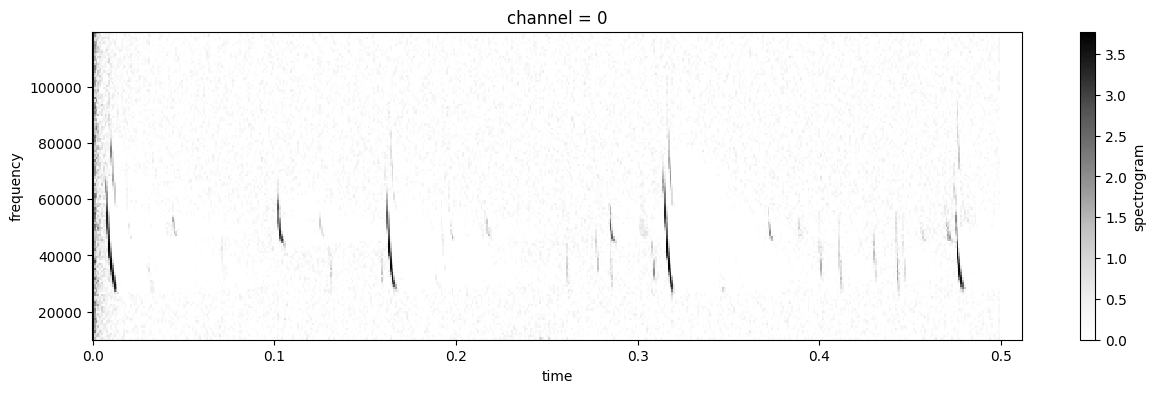

In [17]:
# Display Spectrogram Dimensions and Shape
print(f"Spectrogram Dimensions: {spectrogram.dims}")
print(f"Spectrogram Shape: {spectrogram.shape}")

# Plot the Spectrogram
spectrogram.plot(figsize=(15, 4), cmap="Greys");

### Detections Array

Each bat call identified in the audio is represented in the `detection_array`, which has the same dimensions as the spectrogram.  This array helps us visually pinpoint the start and frequency range of each detected bat call:

* Gaussian Point Marking: A small Gaussian point (a concentrated dot) is placed at the lower-left corner of each bat call's location on the spectrogram.
* Start Time and Frequency: The Gaussian point marks the exact time the bat call begins and the call's lowest frequency.

Let's visualize the locations of these bat calls on the spectrogram to better understand how the the call location is represented.

Detection Array Dimensions: ('frequency', 'time')
Detection Array Shape: (128, 512)


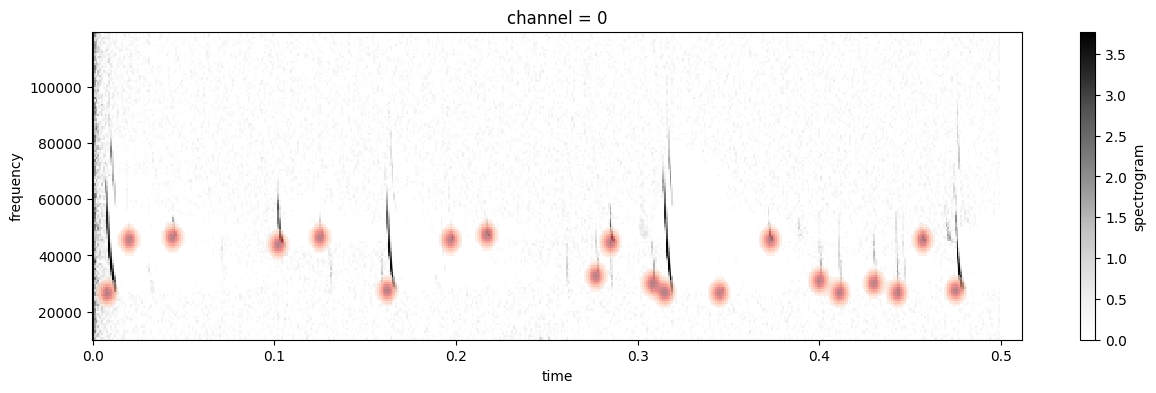

In [18]:
# Display Detection Array Dimensions and Shape
print(f"Detection Array Dimensions: {detection_array.dims}")
print(f"Detection Array Shape: {detection_array.shape}")

# Plot the grayscale spectrogram on the axes
_, ax = plt.subplots(figsize=(15, 4))
spectrogram.plot(ax=ax, cmap="Greys")

# Overlay the detections on top of the spectrogram
detection_array.where(detection_array > 0.1).plot(
    ax=ax,  # Plot on the same axes as the spectrogram
    alpha=0.5,  # Set transparency of the detection overlays
    vmin=0,  # Minimum value for the colormap
    vmax=1,  # Maximum value for the colormap
    add_colorbar=False,  # Don't add a separate colorbar for detections
    cmap="Reds",  # Use a red colormap for the detections
)

### Predicted Class Probabilities

The `class_array` also has the same dimensions as the spectrogram, but with an additional dimension to represent the probability of each location belonging to each bat call class (species or social call). This allows us to visualize where the model is most confident in its predictions.

Class Array Dimensions: ('category', 'frequency', 'time')
Class Array Shape: (4, 128, 512)


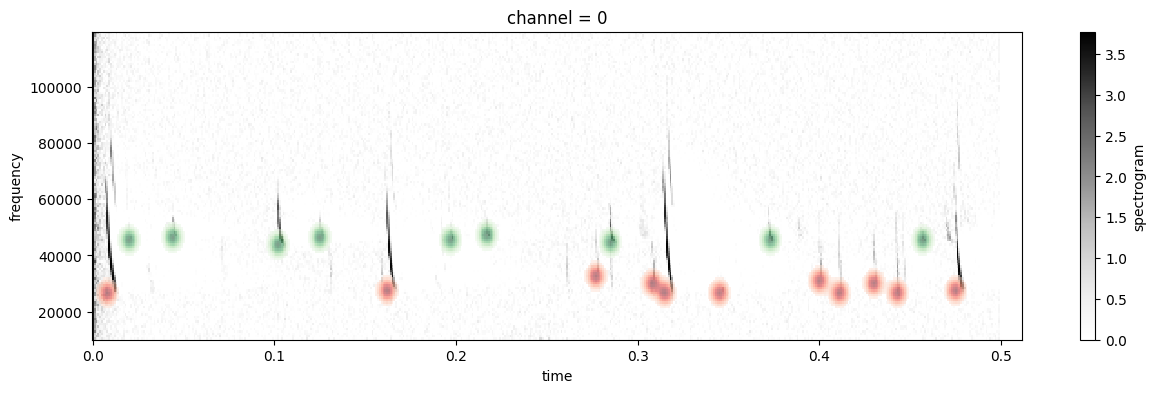

In [19]:
# Display Class Array Dimensions and Shape
print(f"Class Array Dimensions: {class_array.dims}")
print(f"Class Array Shape: {class_array.shape}")

# Plot the grayscale spectrogram as the base layer
_, ax = plt.subplots(figsize=(15, 4))
spectrogram.plot(ax=ax, cmap="Greys")

# Define colormaps for each class
cmaps = {
    "Eptesicus serotinus": "Reds",
    "Myotis mystacinus": "Blues",
    "Pipistrellus pipistrellus": "Greens",
    "Rhinolophus ferrumequinum": "Purples",
    "social": "Greys",
    "Bat": "Oranges",
}

# Iterate through each class label
for class_label in class_array.category.values:

    # Select the 2D probability array for the current class
    array = class_array.sel(category=class_label)

    # Overlay the class probabilities on the spectrogram, highlighting areas above a threshold
    array.where(array > 0.1).plot(
        vmin=0,  # Minimum probability for the colormap
        vmax=1,  # Maximum probability for the colormap
        alpha=0.5,  # Set transparency to see the spectrogram underneath
        cmap=cmaps[class_label],  # Use the appropriate colormap for the class
        add_colorbar=False,  # Don't add separate colorbars for each class
        add_labels=False,  # Don't add axis labels (they're already on the plot)
    )

### Bat Call Sizes

The `size_array` provides information about the size of each detected bat call in terms of its duration (length in time) and bandwidth (range of frequencies).

**Note**: The size values in the `size_array` are stored relative to the resolution of the spectrogram. This means they represent proportions of the spectrogram's time and frequency dimensions rather than absolute values in seconds and Hertz. This relative scaling is beneficial for machine learning, as it keeps the values within a manageable range for the model to learn.

Size Array Dimensions: ('dimension', 'frequency', 'time')
Size Array Shape: (2, 128, 512)


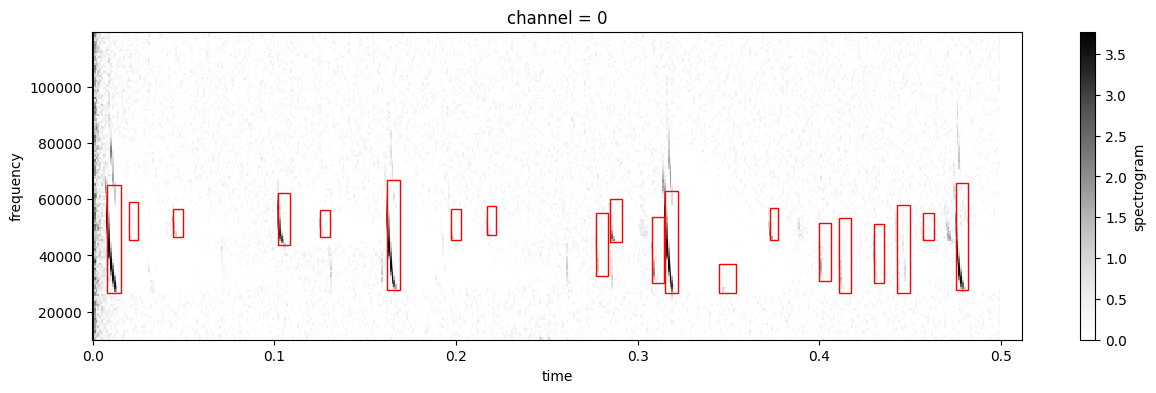

In [23]:
# Display Size Array Dimensions and Shape
print(f"Size Array Dimensions: {size_array.dims}")
print(f"Size Array Shape: {size_array.shape}")

# Plot the grayscale spectrogram as the base layer
_, ax = plt.subplots(figsize=(15, 4))
spectrogram.plot(ax=ax, cmap="Greys")

# Find non-zero size locations
indices = np.argwhere((size_array != 0).any(dim="dimension").values)

for freq_idx, time_idx in indices:
    # Get size at this location
    point = size_array.isel(time=time_idx, frequency=freq_idx)

    # Calculate width in seconds
    width = point.sel(dimension="width") / config.heatmaps.time_scale

    # Calculate height in Hz
    height = point.sel(dimension="height") / config.heatmaps.frequency_scale

    # Draw rectangle
    ax.add_artist(
        Rectangle((point.time, point.frequency), width, height, ec="red", fc="none")
    )

### Metadata Attributes

In addition to the data arrays, each NetCDF file contains important metadata attributes that provide context and traceability. These attributes include the preprocessing configuration and the original clip annotation.

In [21]:
# Get config as JSON string
config_attr = example.attrs["config"]

# Load and validate configuration from JSON string
loaded_config = TrainPreprocessingConfig.model_validate_json(config_attr)

# Ensure the loaded config matches the one used
assert config == loaded_config

# Get annotation as JSON string
clip_annotation_json = example.attrs["clip_annotation"]

# Load and validate clip annotation from JSON string
clip_annotation = data.ClipAnnotation.model_validate_json(clip_annotation_json)

# Display the annotation type
print(type(clip_annotation))

<class 'soundevent.data.clip_annotations.ClipAnnotation'>
